En este notebook vamos a desarrollar la idea de intentar cruzar negocios con opiniones, y con esto ver ver si las puntuaciones y el sentimiento del último mes, junto a la puntuación total y el número de revisiones, pueden tener algún tipo de impacto en el cierre de los diferentes 
negocios.<br><br>
Para hacer esto, primero vamos a realizar una limpieza de la base de datos cruzada, después un analista de correlaciones para ver a priori si es una buena idea realizar esta predicción y por último vamos a emplear varios clasificadores, usando un meta clasificador de stacking para conseguir los mejores resultados.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn as skl
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
#from mlxtend.classifier import StackingClassifier


## ¿Cuál es el mejor tipo de negocio?

Para evaluar cual es el mejor tipo de negocio en general, vamos a ver dentro de las medidas que tenemos (puntuaciones totales, puntuaciones en el último mes y sentimiento en el último mes), vamos a elegir solo los mejores y los peores (puntuacion por encima de 4 o por debajo de 2) y vamos a ver si hay algún tipo de negocio que sería bueno evitar y si hay alguno que debería ser buena idea elegir.



In [4]:
abiertos=df.groupby("abierto").get_group(1)
buenossiempre = abiertos.loc[abiertos['puntuacion_promedio'] >= 4, abiertos.columns[5:]]
malossiempre = abiertos.loc[abiertos['puntuacion_promedio'] <= 2, abiertos.columns[5:]]
buenosultimomes = abiertos.loc[abiertos['puntuacion_ultimo_mes'] >= 4, abiertos.columns[5:]]
malosultimomes = abiertos.loc[abiertos['puntuacion_ultimo_mes'] <= 2, abiertos.columns[5:]]
buenossentimiento = abiertos.loc[abiertos['sentimiento'] >= 4, abiertos.columns[5:]]
malossentimiento = abiertos.loc[abiertos['sentimiento'] <= 2, abiertos.columns[5:]]

### Distribucion de negocios segun la puntuacion media

In [29]:
c=pd.DataFrame([])
a=buenossiempre.mean().sort_values(ascending=False).iloc[0:5]
b=malossiempre.mean().sort_values(ascending=False).iloc[0:5]
c["buenos"]=(a*100).round(2)
c["malos"]=(b*100).round(2)
c=c.fillna(0)
c["diferencia"]=(c["buenos"]-c["malos"]).round(2)
c["buenos"]=c["buenos"].astype(str) + ' %'
c["malos"]=c["malos"].astype(str) + ' %'
c["diferencia"]=c["diferencia"].astype(str) + ' %'
c

,buenos,malos,diferencia
Restaurants,22.13 %,21.61 %,0.52 %
Shopping,16.52 %,16.27 %,0.25 %
Food,14.84 %,11.26 %,3.58 %
Beauty & Spas,12.78 %,0.0 %,12.78 %
Home Services,11.99 %,18.57 %,-6.58 %


### Distribucion de negocios segun la puntuacion media en el ultimo mes

In [30]:
c=pd.DataFrame([])
a=buenosultimomes.mean().sort_values(ascending=False).iloc[0:5]
b=malosultimomes.mean().sort_values(ascending=False).iloc[0:5]
c["buenos"]=(a*100).round(2)
c["malos"]=(b*100).round(2)
c=c.fillna(0)
c["diferencia"]=(c["buenos"]-c["malos"]).round(2)
c["buenos"]=c["buenos"].astype(str) + ' %'
c["malos"]=c["malos"].astype(str) + ' %'
c["diferencia"]=c["diferencia"].astype(str) + ' %'
c

,buenos,malos,diferencia
Restaurants,22.83 %,24.28 %,-1.45 %
Shopping,17.26 %,17.83 %,-0.57 %
Food,14.28 %,12.85 %,1.43 %
Beauty & Spas,11.82 %,0.0 %,11.82 %
Home Services,11.7 %,14.28 %,-2.58 %


### Distribucion de negocios segun los sentimientos media en el ultimo mes

In [31]:
c=pd.DataFrame([])
a=buenossentimiento.mean().sort_values(ascending=False).iloc[0:5]
b=malossentimiento.mean().sort_values(ascending=False).iloc[0:5]
c["buenos"]=(a*100).round(2)
c["malos"]=(b*100).round(2)
c=c.fillna(0)
c["diferencia"]=(c["buenos"]-c["malos"]).round(2)
c["buenos"]=c["buenos"].astype(str) + ' %'
c["malos"]=c["malos"].astype(str) + ' %'
c["diferencia"]=c["diferencia"].astype(str) + ' %'
c

,buenos,malos,diferencia
Restaurants,23.23 %,32.11 %,-8.88 %
Shopping,18.33 %,15.8 %,2.53 %
Food,14.89 %,15.1 %,-0.21 %
Beauty & Spas,13.39 %,0.0 %,13.39 %
Health & Medical,10.04 %,0.0 %,10.04 %


Habiendo visto las distribuciones porcentuales de los negocios según las diferentes medidas podemos ver que hay 3 tipos de negocios que siempre están en el top de medidas buenas y malas, que son Restaurants, Shopping and Food. Los cuales no aseguran que vayas a triunfar, pero también se pueden encontrar otras 2 cosas curiosas. <br><br>
Si bien Home Service aparece tanto en los buenos como los malos, son más predominante en los negocios malos, siendo quizás un negocio a evitar. <br><br>
 Por otro lado podemos ver que hay una categoría diferente, que aparece en el top 4 en las buenas pero no aparece en las malas, qué es Beauty & Spas. <br><br>
Como resumen, podemos concluir que Restaurants, Shopping y Food son buenas ideas para abrir, pero tienen más riesgo que otros tipos de negocio, Home Service seria una peor idea que las anteriores, pero tambien podria salir bien y por último, si abres un negocio del tipo Beauty & Spas puede que no tenga tanto impacto como los anteriores, pero es probable que tengas menos malas críticas.



## Mejores negocios para las tres principales ciudades

Ahora una vez visto los negocios que serian más recomendables en general vamos a tratar de ver que tipo de negocio seria más recomendable para las tres principales ciudades: Toronto, Las Vegas y Phoenix. Teniendo en cuenta la puntuaciones del ultimo mes de los negocios

In [32]:
a=df_ciudades
a=df_ciudades.drop(list(df_ciudades.columns)[0],axis=1)
a=a.drop(list(a.columns)[4:5], axis=1)
a=a.drop(list(a.columns)[5:7], axis=1)
a=a.drop(list(a.columns)[10], axis=1)


In [33]:
abiertos= a.groupby("abierto").get_group(1)
toronto=abiertos.groupby("ciudad").get_group("Toronto")
phoenix=abiertos.groupby("ciudad").get_group("Phoenix")
vegas=abiertos.groupby("ciudad").get_group("Las Vegas")



Ahora mismo ya contamos con todos los negocios separados por estas ciudades. Por lo que en primer lugar vamos a ver que tipo de negocios seria más recomendable para Toronto.

### Negocios Toronto

In [38]:
buenosultimomes = toronto.loc[abiertos['puntuacion_ultimo_mes'] >= 4, toronto.columns[10:]]
malosultimomes = toronto.loc[abiertos['puntuacion_ultimo_mes'] <= 2, toronto.columns[10:]]

In [39]:
a=buenosultimomes.mean()
a.sort_values(ascending=False).head(10)
c=pd.DataFrame([])
a=buenosultimomes .mean().sort_values(ascending=False).iloc[0:5]
b=buenosultimomes .mean().sort_values(ascending=False).iloc[0:5]
c["buenos"]=(a*100).round(2)
c["malos"]=(b*100).round(2)
c=c.fillna(0)
c["diferencia"]=(c["buenos"]-c["malos"]).round(2)
c["buenos"]=c["buenos"].astype(str) + ' %'
c["malos"]=c["malos"].astype(str) + ' %'
c["diferencia"]=c["diferencia"].astype(str) + ' %'
c

,buenos,malos,diferencia
Restaurants,34.34 %,34.34 %,0.0 %
Food,21.95 %,21.95 %,0.0 %
Shopping,18.88 %,18.88 %,0.0 %
Beauty & Spas,12.36 %,12.36 %,0.0 %
Nightlife,8.26 %,8.26 %,0.0 %


Habiendo visto las distribuciones porcentuales de los negocios para Toronto podemos ver que hay 3 tipos de negocios que están en el top, que son Restaurants, Shopping and Food. Los cuales no aseguran que vayas a triunfar, pero también se pueden encontrar otras cosas curiosas.

Se puede observar que detro de los negocios consideramos como buenos aparece entre el top 5, los negocios nocturnos los cuales no llegan a aparecer en el top 5 sino que pasan a bajar al top 8.

También podemos observar que Home services no llega a aparecer dentro del top de los buenos y si embargo dentro de los malos si que aparece, lo que puede llegar a indicar que en Toronto no llegue a triunfar un negocio relacionado con Home service.

Como resumen, podemos concluir que Restaurants, Shopping y Food son buenas ideas para abrir, pero tienen más riesgo que otros tipos de negocio, Home Service seria una peor idea que las anteriores. Esto es lo que se puede llegar a decir de Toronto e incluso sería un punto beneficioso contar con la posibilidad de abrir un negocio relacionado con el Nightlife.

### Negocios Phoenix

In [40]:
buenosultimomes = phoenix.loc[abiertos['puntuacion_ultimo_mes'] >= 4, phoenix.columns[10:]]
malosultimomes = phoenix.loc[abiertos['puntuacion_ultimo_mes'] <= 2, phoenix.columns[10:]]

In [41]:
a=buenosultimomes.mean()
a.sort_values(ascending=False).head(10)
c=pd.DataFrame([])
a=buenosultimomes .mean().sort_values(ascending=False).iloc[0:5]
b=buenosultimomes .mean().sort_values(ascending=False).iloc[0:5]
c["buenos"]=(a*100).round(2)
c["malos"]=(b*100).round(2)
c=c.fillna(0)
c["diferencia"]=(c["buenos"]-c["malos"]).round(2)
c["buenos"]=c["buenos"].astype(str) + ' %'
c["malos"]=c["malos"].astype(str) + ' %'
c["diferencia"]=c["diferencia"].astype(str) + ' %'
c

,buenos,malos,diferencia
Home Services,18.34 %,18.34 %,0.0 %
Shopping,17.22 %,17.22 %,0.0 %
Restaurants,14.42 %,14.42 %,0.0 %
Health & Medical,14.17 %,14.17 %,0.0 %
Local Services,12.38 %,12.38 %,0.0 %


Habiendo visto las distribuciones porcentuales de los negocios para Phoenix podemos ver que hay 3 tipos de negocios que están en el top, que son Restaurants, Shopping and Home services. Los cuales no aseguran que vayas a triunfar, pero también se pueden encontrar otras cosas curiosas.

Se puede observar que la cantidad de negocios de Home services que cuenta con una mala puntuación es superior, lo que puede llegar a indicar que no vayan a ser del todo buenos.

Como resumen, podemos concluir que Restaurants, Shopping y Home services son buenas ideas para abrir, pero tienen más riesgo que otros tipos de negocio. Esto es lo que se puede llegar a decir de Phoenix.

### Negocios Las Vegas

In [42]:
buenosultimomes = vegas.loc[abiertos['puntuacion_ultimo_mes'] >= 4, vegas.columns[10:]]
malosultimomes = vegas.loc[abiertos['puntuacion_ultimo_mes'] <= 2, vegas.columns[10:]]

In [43]:
a=buenosultimomes.mean()
a.sort_values(ascending=False).head(10)
c=pd.DataFrame([])
a=buenosultimomes .mean().sort_values(ascending=False).iloc[0:5]
b=buenosultimomes .mean().sort_values(ascending=False).iloc[0:5]
c["buenos"]=(a*100).round(2)
c["malos"]=(b*100).round(2)
c=c.fillna(0)
c["diferencia"]=(c["buenos"]-c["malos"]).round(2)
c["buenos"]=c["buenos"].astype(str) + ' %'
c["malos"]=c["malos"].astype(str) + ' %'
c["diferencia"]=c["diferencia"].astype(str) + ' %'
c

,buenos,malos,diferencia
Shopping,17.95 %,17.95 %,0.0 %
Home Services,14.82 %,14.82 %,0.0 %
Restaurants,13.64 %,13.64 %,0.0 %
Beauty & Spas,13.27 %,13.27 %,0.0 %
Health & Medical,13.26 %,13.26 %,0.0 %


Habiendo visto las distribuciones porcentuales de los negocios para Phoenix podemos ver que hay 3 tipos de negocios que están en el top, que son Restaurants, Shopping and Home services. Los cuales no aseguran que vayas a triunfar, pero también se pueden encontrar otras cosas curiosas.

Se puede observar que la cantidad de negocios de Home services que cuenta con una mala puntuación es superior, lo que puede llegar a indicar que no vayan a ser del todo buenos.

Como resumen, podemos concluir que Restaurants, Shopping y Home services son buenas ideas para abrir, pero tienen más riesgo que otros tipos de negocio. Aunque si se tuviera que elegir que tipo de negocis abrir en La Vegas serian de tipo Shopping. Esto es lo que se puede llegar a decir de Phoenix.

## Limpieza


<p>Para este analisis, eliminamos columnas que consideramos innecesarias. Estas son todas las de localización espacial e identificación, cosas que no queres evaluar para poder extrapolar este conocimiento a todo EEUU o directamente son inutiles como la id. </p>

In [2]:
df = pd.read_csv("../Dataset/Datos_opiniones_negocios_unido.csv")
df=df.rename(columns={"puntuacion_x": "puntuacion_ultimo_mes", "puntuacion_y": "puntuacion_promedio"})
df_ciudades = df
df=df.drop(list(df.columns)[0],axis=1)
df=df.drop(list(df.columns)[2:10],axis=1)
df=df.drop(list(df.columns)[5],axis=1)
df

,puntuacion_ultimo_mes,sentimiento,puntuacion_promedio,num_revisiones,abierto,Wineries,Waldorf Schools,Immunodermatologists,Astrologers,Parking,...,Event Photography,Cabaret,Pet Adoption,Home Theatre Installation,Middle Eastern,Religious Schools,Pet Cremation Services,Condominiums,Churros,Mags
0,1.500000,2.564435,4.0,24,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.500000,2.779421,3.0,44,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4.666667,3.325761,4.0,58,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.000000,2.462500,3.5,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.000000,2.208333,3.5,12,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4.200000,3.373947,4.0,1613,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,4.000000,3.142050,3.5,49,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,3.000000,2.610303,3.0,5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1.000000,2.337963,3.0,7,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,4.000000,3.685211,4.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Correlaciones

Creamos una nueva columna que sea la diferencia entre la puntuación del último mes y la promedio, que representa el cómo le ha ido al negocio, de una forma fácil de entender para nosotros y realizamos el análisis de correlación.

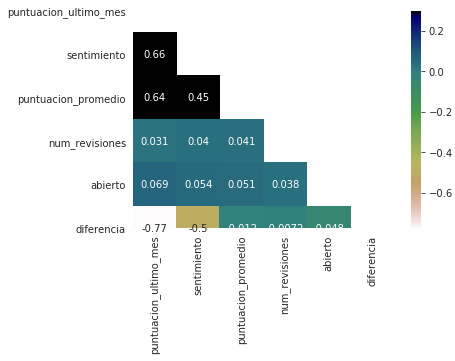

<Figure size 1440x1440 with 0 Axes>

In [9]:
df2=df.drop(list(df.columns)[5:],axis=1)
df2["diferencia"]=df2["puntuacion_promedio"]-df2["puntuacion_ultimo_mes"]
a=df2.corr()
mask = np.zeros_like(a)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    sns.heatmap(a, mask=mask, vmax=.3, square=True,cmap="gist_earth_r",annot=True )
plt.figure(figsize=(20,20))
plt.show()

En este análisis de correlación evaluamos la puntuación promedio, sentimiento y puntuación del último mes y encontramos que estas tres columnas estén muy correladas, las demás apenas, salvo la diferencia ente puntuación promedio y la del último mes, las cuales tienen una fuerte correlación inversa con respecto de la puntuación del último mes y al sentimiento.<br><br>
Lo más reseñable de todo esto, es que no hay una relación aparente con abierto.


## Predictor

Como se ha dicho previamente, a la hora de realizar la separación de atributos para el predictor, se utilizara como clase la columna abierto, la cual indica si el negocio sigue en funcionamiento o no, y como atributos, la puntuación promedio del sentimiento obtenida al analizar la reviews,  la puntuación del último mes, la puntuación promedio, el número de revisiones y los tipos de negocios

In [4]:
y=df["abierto"]
x=df.drop(list(df.columns)[4],axis=1)

A la hora de realizar este experimento, se ha decidido usar un conjunto de clasificadores (Random Forest, KNN y Gaussian Naive Bayes) que utilizan un meta clasificador de stacking( Logistic Regression) y para la separación de test y entrenamiento, hemos usado cross validation con 4 folds.<br>
Para evaluar los resultados obtenidos de estos clasificadores, vamos a emplear como medidas la accuracy, la precisión, el f1 score y el roc_auc.

In [9]:
clf2 = RandomForestClassifier(random_state=1,n_estimators=20)
clf3 = KNeighborsClassifier(n_neighbors=2)
clf4 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf2,clf3,clf4],meta_classifier=lr)

print("4-fold cross validation:\n")

for clf,label in zip([clf2,clf3,clf4,sclf],["Random forest","KNN","Naive bayes","StackingClassifier"]):
    scores=cross_val_score(clf,x,y,cv=4, scoring="accuracy")
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))
    scores=cross_val_score(clf,x,y,cv=4, scoring="precision")
    print("Precision: %0.2f (+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))
    scores=cross_val_score(clf,x,y,cv=4, scoring="f1")
    print("F1: %0.2f (+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))
    scores=cross_val_score(clf,x,y,cv=4, scoring="roc_auc")
    print("roc_auc: %0.2f (+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))
    print("\n-------------------------------------------------------------------\n")

4-fold cross validation:

Accuracy: 0.81 (+/- 0.00) [Random forest]
Precision: 0.85 (+/- 0.00) [Random forest]
F1: 0.89 (+/- 0.00) [Random forest]
roc_auc: 0.72 (+/- 0.00) [Random forest]

-------------------------------------------------------------------

Accuracy: 0.69 (+/- 0.00) [KNN]
Precision: 0.87 (+/- 0.00) [KNN]
F1: 0.79 (+/- 0.00) [KNN]
roc_auc: 0.61 (+/- 0.00) [KNN]

-------------------------------------------------------------------

Accuracy: 0.38 (+/- 0.00) [Naive bayes]
Precision: 0.94 (+/- 0.00) [Naive bayes]
F1: 0.41 (+/- 0.00) [Naive bayes]
roc_auc: 0.70 (+/- 0.00) [Naive bayes]

-------------------------------------------------------------------

Accuracy: 0.82 (+/- 0.00) [StackingClassifier]
Precision: 0.84 (+/- 0.00) [StackingClassifier]
F1: 0.89 (+/- 0.00) [StackingClassifier]
roc_auc: 0.60 (+/- 0.00) [StackingClassifier]

-------------------------------------------------------------------



Antes de empezar a analizar los resultados, tenemos que mencionar un fallo de base en el planteamiento de este experimento, y es que las clases están muy desbalanceadas, habiendo unos 159000 negocios abiertos frente a 33000 negocios cerrados (83%/17%).<br><br>
Sabiendo esto si miramos la medida de <b>precision</b> <i>(verdaderos positivos/(falsos positivos+verdaderos negativos))</i> podemos observar que el valor es más o menos igual porcentaje de abiertos y cerrados, indicándonos que está poniendo a todos o casi todos los negocios valor de abierto, al menos en todos los clasificadores salvo en naive bayes, no obstante, los resultados de este son muy malos, tanto que su accuracy nos indica que es peor que poner clases al azar, ya que está por debajo del 50% <br><br>
Para hacer un resumen de este experimento, podemos ver que el mejor predictor es Random Forest, seguido del stacking el cual tiene peor curva roc y ligeramente peor precisión.<br><br>
Después de observar esto vamos a replantear el experimento para ello vamos a seleccionar tantos negocios abiertos como haya cerrados, para balancear las clases. 


In [4]:
grouped=df.groupby("abierto")
dfAbiertos=grouped.get_group(1).reset_index()
dfAbiertos["abierto"]=1
dfCerrados=grouped.get_group(0).reset_index()
dfCerrados["abierto"]=0
dfTemp=dfCerrados.copy()
dfTemp=pd.concat([dfTemp,dfAbiertos.loc[dfAbiertos.index < len(list(dfCerrados.index))]],ignore_index=True)
df2 = skl.utils.shuffle(dfTemp).reset_index()
y=df2["abierto"]
x=df2.drop(list(df2.columns)[0:2],axis=1)
x=x.drop(list(x.columns)[4],axis=1)
clf2 = RandomForestClassifier(random_state=1,n_estimators=20)
clf3 = KNeighborsClassifier(n_neighbors=2)
clf4 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf2,clf3,clf4],meta_classifier=lr)

print("4-fold cross validation:\n")
for clf,label in zip([clf2,clf3,clf4,sclf],["Random forest","KNN","Naive bayes","StackingClassifier"]):
    scores=cross_val_score(clf,x,y,cv=4, scoring="accuracy")
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))
    scores=cross_val_score(clf,x,y,cv=4, scoring="precision")
    print("Precision: %0.2f (+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))
    scores=cross_val_score(clf,x,y,cv=4, scoring="f1")
    print("F1: %0.2f (+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))
    scores=cross_val_score(clf,x,y,cv=4, scoring="roc_auc")
    print("roc_auc: %0.2f (+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))
    print("\n-------------------------------------------------------------------\n")

4-fold cross validation:

Accuracy: 0.67 (+/- 0.00) [Random forest]
Precision: 0.69 (+/- 0.00) [Random forest]
F1: 0.65 (+/- 0.00) [Random forest]
roc_auc: 0.73 (+/- 0.00) [Random forest]

-------------------------------------------------------------------

Accuracy: 0.59 (+/- 0.00) [KNN]
Precision: 0.67 (+/- 0.00) [KNN]
F1: 0.48 (+/- 0.01) [KNN]
roc_auc: 0.64 (+/- 0.00) [KNN]

-------------------------------------------------------------------

Accuracy: 0.60 (+/- 0.00) [Naive bayes]
Precision: 0.79 (+/- 0.01) [Naive bayes]
F1: 0.40 (+/- 0.00) [Naive bayes]
roc_auc: 0.70 (+/- 0.01) [Naive bayes]

-------------------------------------------------------------------

Accuracy: 0.66 (+/- 0.00) [StackingClassifier]
Precision: 0.66 (+/- 0.00) [StackingClassifier]
F1: 0.67 (+/- 0.00) [StackingClassifier]
roc_auc: 0.67 (+/- 0.00) [StackingClassifier]

-------------------------------------------------------------------



Después del experimento anterior, el cual estaba destinado a fracasar desde el principio realizamos un nuevo conjunto de experimento, en el cual se realizó una selección de tantos abiertos como cerrados, cerrados tras esto una unión de la selección de abiertos  a los cerrados y aleatorización para evitar que encontrasen patrones los algoritmos y se procedió a repetir el experimento.<br><br>
Ahora sí se puede observar que los resultados tienen más sentido, ya que las clases están balanceadas, pero obtenemos “peores resultados” numéricos. Podemos observar que tanto KNN como Gaussian Naive Bayes obtienen unas medidas  de error no muy malas, pero si f1 score es nefasto. Por lo demás todas las medidas rondan el 60% y el 70%.<br><br>
Finalmente podemos ver que el mejor predictor es Random Forest, seguido del stacking el cual tiene mejor f1 pero peor curva roc, accuracy and precision.
